In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

# Preprocesado y modelado
# ==============================================================================
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Datos
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/' \
       + 'Estadistica-machine-learning-python/master/data/ESL.mixture.csv'
datos = pd.read_csv(url)
datos.head(3)

,X1,X2,y
0,2.526093,0.321050,0
1,0.366954,0.031462,0
2,0.768219,0.717486,0


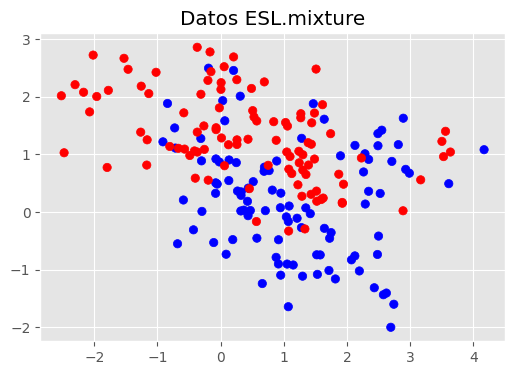

In [3]:
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(datos.X1, datos.X2, c=datos.y);
ax.set_title("Datos ESL.mixture");


## SVM LINEAL

In [4]:
# División de los datos en train y test
# ==============================================================================
X = datos.drop(columns = 'y')
y = datos['y']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [5]:
# Creación del modelo SVM lineal
# ==============================================================================
modelo = SVC(C = 100, kernel = 'linear', random_state=123)
modelo.fit(X_train, y_train)

SVC(C=100, kernel='linear', random_state=123)

Text(0.5, 1.0, 'Resultados clasificación SVM lineal')

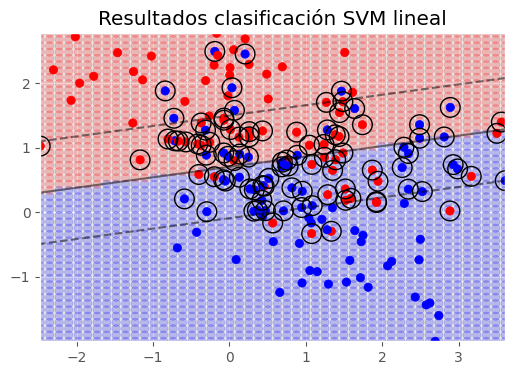

In [6]:
# Representación gráfica de los límites de clasificación
# ==============================================================================
# Grid de valores
x = np.linspace(np.min(X_train.X1), np.max(X_train.X1), 50)
y = np.linspace(np.min(X_train.X2), np.max(X_train.X2), 50)
Y, X = np.meshgrid(y, x)
grid = np.vstack([X.ravel(), Y.ravel()]).T

# Predicción valores grid
pred_grid = modelo.predict(grid)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(grid[:,0], grid[:,1], c=pred_grid, alpha = 0.2)
ax.scatter(X_train.X1, X_train.X2, c=y_train, alpha = 1)

# Vectores soporte
ax.scatter(
    modelo.support_vectors_[:, 0],
    modelo.support_vectors_[:, 1],
    s=200, linewidth=1,
    facecolors='none', edgecolors='black'
)

# Hiperplano de separación
ax.contour(
    X,
    Y,
    modelo.decision_function(grid).reshape(X.shape),
    colors = 'k',
    levels = [-1, 0, 1],
    alpha  = 0.5,
    linestyles = ['--', '-', '--']
)

ax.set_title("Resultados clasificación SVM lineal")

In [7]:
# Predicciones test
# ==============================================================================
predicciones = modelo.predict(X_test)
predicciones

array([1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0])

In [8]:
# Accuracy de test del modelo
# ==============================================================================
accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )
print("")
print(f"El accuracy de test es: {100*accuracy}%")


El accuracy de test es: 70.0%


## SVM RADIAL

In [9]:
# Grid de hiperparámetros
# ==============================================================================
param_grid = {'C': np.logspace(-5, 7, 20)}

# Búsqueda por validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = SVC(kernel= "rbf", gamma='scale'),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = -1,
        cv         = 3, 
        verbose    = 0,
        return_train_score = True
      )

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(5)

,param_C,mean_test_score,std_test_score,mean_train_score,std_train_score
8,1.128838,0.762520,0.023223,0.790778,0.035372
12,379.269019,0.750641,0.076068,0.868777,0.007168
7,0.263665,0.750175,0.030408,0.778228,0.026049
9,4.832930,0.744118,0.044428,0.815729,0.026199
11,88.586679,0.738062,0.064044,0.859431,0.019840


In [10]:


# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

modelo = grid.best_estimator_



----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'C': np.float64(1.1288378916846884)} : 0.7625203820172374 accuracy


Text(0.5, 1.0, 'Resultados clasificación SVM radial')

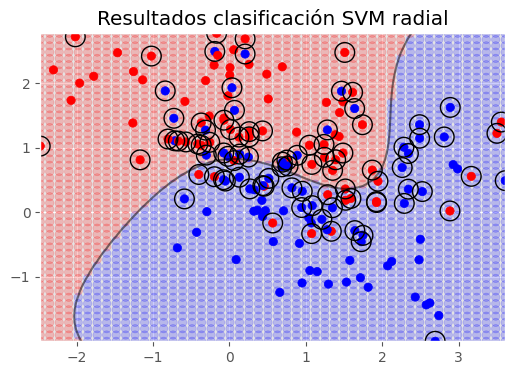

In [11]:
# Representación gráfica de los límites de clasificación
# ==============================================================================
# Grid de valores
x = np.linspace(np.min(X_train.X1), np.max(X_train.X1), 50)
y = np.linspace(np.min(X_train.X2), np.max(X_train.X2), 50)
Y, X = np.meshgrid(y, x)
grid = np.vstack([X.ravel(), Y.ravel()]).T

# Predicción valores grid
pred_grid = modelo.predict(grid)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(grid[:,0], grid[:,1], c=pred_grid, alpha = 0.2)
ax.scatter(X_train.X1, X_train.X2, c=y_train, alpha = 1)

# Vectores soporte
ax.scatter(
    modelo.support_vectors_[:, 0],
    modelo.support_vectors_[:, 1],
    s=200, linewidth=1,
    facecolors='none', edgecolors='black'
)

# Hiperplano de separación
ax.contour(
    X,
    Y,
    modelo.decision_function(grid).reshape(X.shape),
    colors='k',
    levels=[0],
    alpha=0.5,
    linestyles='-'
)

ax.set_title("Resultados clasificación SVM radial")

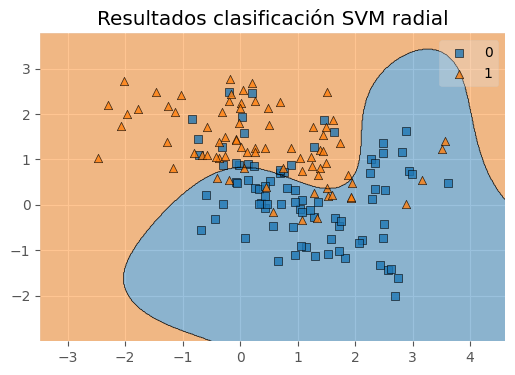

In [12]:
# Representación gráfica utilizando plot_decision_regions() de mlxtend
# ==============================================================================
fig, ax = plt.subplots(figsize=(6,4))
plot_decision_regions(
    X = X_train.to_numpy(),
    y = y_train.flatten(),
    clf = modelo,
    ax = ax
)
ax.set_title("Resultados clasificación SVM radial");

In [13]:

# Predicciones test
# ==============================================================================
predicciones = modelo.predict(X_test)


In [14]:
# Accuracy de test del modelo 
# ==============================================================================
accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )
print("")
print(f"El accuracy de test es: {100*accuracy}%")



El accuracy de test es: 80.0%


In [15]:
# Matriz de confusión de las predicciones de test
# ==============================================================================
confusion_matrix = pd.crosstab(
    y_test.ravel(),
    predicciones,
    rownames=['Real'],
    colnames=['Predicción']
)
confusion_matrix

Predicción,0,1
Real,,
0,14,3
1,5,18
